# Python for Fantasy Football - Addressing Class Imbalance in Machine Learning

Welcome to part 6 of my 'Python for Fantasy Football' series! In this article we will be looking at strategies for addressing class imbalance in machine learning. In __[part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__ I introduced some basic machine learning concepts and explained why I have decided to focus on expected goals for this introductory series, so if you haven't already please go back and read through that before continuing.

__[Part 1](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__, __[Part 2](http://www.fantasyfutopia.com/python-for-fantasy-football-matchup-adjustment/)__, __[Part 3](http://www.fantasyfutopia.com/python-for-fantasy-football-getting-and-cleaning-data/)__, __[Part 4](http://www.fantasyfutopia.com/python-for-fantasy-football-apis-and-json-data/)__, __[Part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__

**Note: part 6 and 7 actually got a lot more technical than I'm comfortable with given that this is supposed to be an introductory series! I highly recommend working through the tutorials on __[Kaggle](https://www.kaggle.com/learn)__ first before you carry on with this series. The last thing I want is for you to get put off machine learning just because I chose a much trickier example than I should have!**

Once again we will be working with the __[StatsBomb FA WSL and NWSL data](https://github.com/statsbomb/open-data)__. It's fantastic that we can access such a good dataset for free, so thanks to __[StatsBomb](https://statsbomb.com/)__ for making it available! I also wanted to thank everyone for all the positive comments, likes, retweets etc - keep them coming! As always, you can follow along in notebook form by using the materials on GitHub __[here](https://github.com/twhelan22/python-for-fantasy-football)__.

## Dealing with class imbalance
Class imbalance is a common issue in machine learning. In an ideal situation we would have a perfect dataset with an equal number of examples for each class, but unfortunately most real-world problems aren't that simple. At least in our case we can be thankful that almost 10% of our dataset is from the minority class - there are many examples of machine learning problems where class imbalance can be significantly higher, for example 99.95/0.05% (think credit card fraud, rare disease detection etc)!

In __[the previous article](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__ we saw how a failure to address class imbalance can cause machine learning models to perform much worse than we might expect initially. By default most algorithms are optimised to try to minimise things like accuracy, which can lead to models that simply classify most of the examples as the majority class. Due to the distribution of the data such a model will be right in its predictions most of the time, but it will also have no predictive power whatsoever. Fortunately, there are a few tactics we can use to address the imbalance in a binary classification problem:

-  Re-frame the problem as anomaly detection, where examples of the minority class are treated as outliers. This might be a good strategy when there is an extreme imbalance present, but is probably not the best approach in our case.
-  Adjust the algorithm parameters to assign higher weight to examples of the minority class. Typically this will cause false negatives to incur a higher penalty than they would otherwise.
-  Balance the original dataset by re-sampling: 
    -  Over-sample the minority class, by randomly duplicating examples until there is a more reasonable split between classes (e.g. 50/50). Since we are working with a small dataset we would just be duplicating the few 'goal' examples in the data, so we would be at risk of overfitting if we used this approach.
    -  Under-sample the majority class. Whilst you are essentially throwing away data this can sometimes be preferable to oversampling to avoid overfitting, but in our case since we have such a small dataset it will almost certainly decrease model performance.
    -  Synthetically create new examples by interpolating between existing ones. Two popular algorithms are SMOTE -  (Synthetic Minority Over-sampling Technique) and ADASYN (Adaptive Synthetic) sampling. The main difference between the two is that ADASYN is weighted and will generate more minority examples that are harder to learn than ones that are easier to learn. These techniques could work well here as we would be creating new examples of goals rather than simply duplicating existing ones, but it's worth remembering that data balancing isn't a substitute for additional data. If there happens to be a situation that isn't present in the original dataset, for instance an overhead kick from outside the box, the algorithm won't be able to generate new examples of that situation. Whilst there is less risk of overfitting than with the 'oversampling' method, it's still a bit of a concern with so few examples of the minority case in our dataset.
-  Create an entirely new sampling algorithm or classification algorithm that handles imbalanced data well. For obvious reasons we won't be doing that here, although specialised algorithms do exist already, so we could make use of them if we wanted. Since we will be exploring different algorithms in the next part in this article series, I won't use this option here.

In this case it looks like our best bet will either be to assign class weights or use synthetic sampling, so we will try both. For now we'll stick with the train_test_split method and use a decision tree classifier, to make it easy to compare the results with those from __[our original model](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__. However, when using any kind of class balancing strategy it's typically better to use cross-validation, as this can mitigate some of the problems with over or underfitting (see here for a detailed explanation). I'll talk more about cross-validation in the final section, but first let's get back to where we left off in __[the previous article](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__:

In [203]:
# Import modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import seaborn as sns
import scikitplot as skplt

from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTENC

# Hide warnings (always delete this if you are writing/checking your own code)
import warnings
warnings.filterwarnings("ignore")

# Load the data from csv to avoid preprocessing steps and make it easier to compare models
np_shots = pd.read_csv('np_shots.csv')

# Select model features and labels
feature_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected',
                'assisted', 'distance', 'angle']

features = np_shots[feature_cols]
labels = np_shots['goal']

# Encode categorical features
cat_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected']

cat_features = features[cat_cols]
features = features.drop(cat_cols, axis=1)

# Use label encoding to convert categorical features to numeric
le = preprocessing.LabelEncoder()
cat_features = cat_features.apply(le.fit_transform)

# Merge with numeric features
features = features.merge(cat_features, left_index=True, right_index=True)

# Split data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.20, shuffle=True, random_state=42)

# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Check that we have the same number of rows and columns in both the training and test set
print(X_train.shape)
print(X_test.shape)

(2032, 13)
(508, 13)


## Adjusting class weights
Many classification algorithms allow you to assign custom weights to each class to help mitigate imbalance by assigning a higher weight to the minority class. In the case of sklearn's decision tree classifier, this can be done by stetting the 'class_weight' option. From the documentation:

*"The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))"*

This sounds like what we want. We can check the actual class weights the model will use via the following code:

In [204]:
# Check class weights that a 'balanced' model would use
class_weights = compute_class_weight('balanced', np.unique(labels), labels)
print(np.unique(labels))
print(class_weights)

[0 1]
[0.55337691 5.18367347]


We can use these weights in our model and see if it makes any difference to performance:

Predicted goals (test set): 55
Sum of predicted goal probabilities (aka xG): 53.83
Actual goals (test set): 51

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       457
           1       0.22      0.24      0.23        51

   micro avg       0.84      0.84      0.84       508
   macro avg       0.57      0.57      0.57       508
weighted avg       0.84      0.84      0.84       508



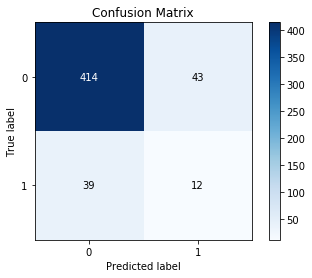

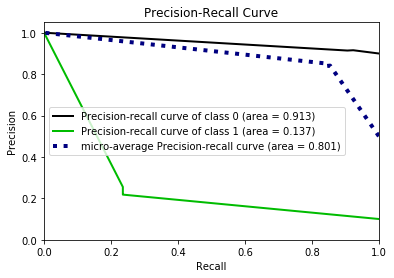

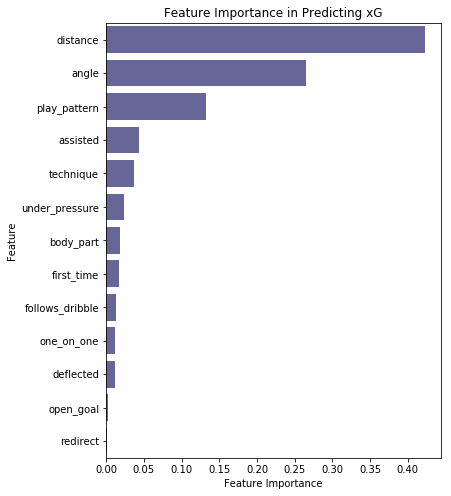

In [205]:
# Define the algorithm we want to use for our model
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Create predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

# Print results
print("Predicted goals (test set):", sum(y_pred))
print("Sum of predicted goal probabilities (aka xG):", "{0:.2f}".format(sum(y_pred_prob[:,1])))
print("Actual goals (test set):", sum(y_test))
print('')
print(metrics.classification_report(y_test, y_pred))

# Plot results
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

skplt.metrics.plot_precision_recall(y_test, y_pred_prob)

# Get feature importance
importances = pd.DataFrame({'feature':features.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

f, ax = plt.subplots(figsize=(6, 8))
g = sns.barplot(x='importance', y='feature', data=importances,
                color="blue", saturation=.2, label="Total")
g.set(xlabel='Feature Importance', ylabel='Feature', title='Feature Importance in Predicting xG')
plt.show()

Not exactly what we were hoping for! The results are arguably worse than the model with no weights assigned. One possible explanation is that there are so few total errors to begin with due to the size of our dataset that penalising them just doesn't have much of an affect on the model performance. Another explanation is our choice of classifier - tree based models are already better than most at handling imbalance without any weighting. We might revisit this type of balancing technique in future articles with different classification algorithms, but for now let's hope that synthetic sampling methods can achieve better results!

## Synthetic sampling
The '__[imbalanced learn](http://imbalanced-learn.org/)__' module is extremely helpful for dealing with class imbalance in machine learning, particularly when it comes to re-sampling. Unfortunately, a big drawback of most SMOTE and ADASYN algorithms is that they don't handle categorical features properly. For instance, imagine our 'body_part' feature can be one of three values, 0 = head, 1 = foot or 2 = other. A SMOTE or ADASYN algorithm might generate new samples with values of 0.981 or 2.03, or some other interpolated value, because it thinks that 'body_part' is a continuous feature. Fortunately there is one variation of the SMOTE algorithm called 'SMOTE-NC' (Synthetic Minority Over-sampling Technique for Nominal and Continuous) that can deal with both categorical and continuous features. Let's try it out!

In [206]:
# Get column indices instead of names for categorical features (required input for SMOTE-NC)
# Remember in Python the first column in a dataset is at index 0, 2nd column is index 1 etc
# E.g. 'play_pattern' is at index 3 in this dataset
cat_cols_ind = []
for key in cat_cols:
    ind = features.columns.get_loc(key)
    cat_cols_ind.append(ind)

# Fit SMOTE-NC
smote_nc = SMOTENC(categorical_features=cat_cols_ind, random_state=42)
features_resampled, labels_resampled = smote_nc.fit_resample(features, labels)

# Split the resampled data into a training set and a test set
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(features_resampled, labels_resampled,
                                                                test_size=0.20, shuffle=True, random_state=42)

# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train_re = scaler.fit_transform(X_train_re)
X_test_re = scaler.fit_transform(X_test_re)

# Check that we have the same number of rows and columns in both the training and test set
# Note that our dataset got bigger thanks to the SMOTE-NC algorithm!
print(X_train_re.shape)
print(X_test_re.shape)

(3672, 13)
(918, 13)


We now have more examples of the minority class, so hopefully we will be able to improve model performance quite a bit! Let's take a look at the results:

Predicted goals (test set): 326
Sum of predicted goal probabilities (aka xG): 329.80
Actual goals (test set): 437

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       481
           1       0.78      0.58      0.66       437

   micro avg       0.72      0.72      0.72       918
   macro avg       0.73      0.71      0.71       918
weighted avg       0.73      0.72      0.71       918



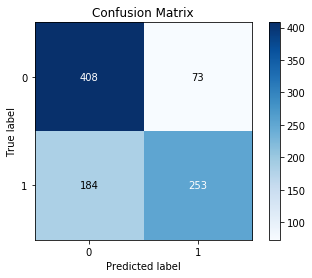

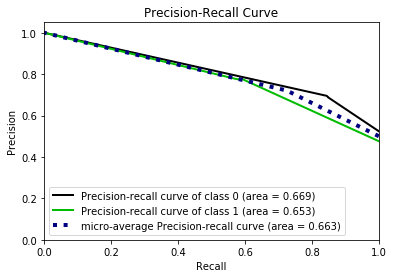

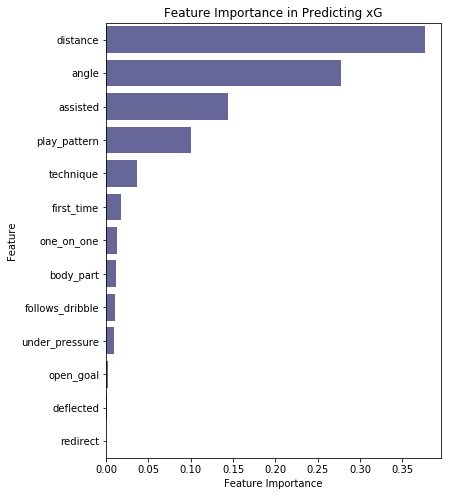

In [207]:
# Define the algorithm we want to use for our model
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train_re, y_train_re)

# Create predictions
y_pred_re = clf.predict(X_test_re)
y_pred_prob_re = clf.predict_proba(X_test_re)

# Print results
print("Predicted goals (test set):", sum(y_pred_re))
print("Sum of predicted goal probabilities (aka xG):", "{0:.2f}".format(sum(y_pred_prob_re[:,1])))
print("Actual goals (test set):", sum(y_test_re))
print('')
print(metrics.classification_report(y_test_re, y_pred_re))

# Plot results
skplt.metrics.plot_confusion_matrix(y_test_re, y_pred_re)

skplt.metrics.plot_precision_recall(y_test_re, y_pred_prob_re)

# Get feature importance
importances = pd.DataFrame({'feature':features.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)

f, ax = plt.subplots(figsize=(6, 8))
g = sns.barplot(x='importance', y='feature', data=importances,
                color="blue", saturation=.2, label="Total")
g.set(xlabel='Feature Importance', ylabel='Feature', title='Feature Importance in Predicting xG')
plt.show()

These results are much more promising! The precision and recall have shot up drastically for 'goal' situations, although this has come at the expense off the 'no goal' class. It looks like we're on the right track with this approach at least! That said, it's disappointing that whilst the number of predicted goals and xG are quite close to each other, these values are quite a bit lower than the actual number of goals in the test set. The model also isn't signing much importance to most of the features, so it might be worth removing some to see if that improves performance. This isn't really surprising with a small dataset; for instance deflected shots account for under 1% of the data. We'll look at improving the model further in the next part, but first let's make sure we aren't over or underestimating model performance by testing using cross-validation instead of the train/test split method.

## Cross-validation
As we know already, it's very important to test machine learning models on data they haven't seen before. If we don't do this, it's likely that the model will be overfitted to the input dataset, and it won't be as useful as it could be in future when we want to use it to predict something based on data it hasn't seen before. The train/test split method provides a simple solution to this problem by holding a portion of the data separate from the training data to use for model testing, but this does have its drawbacks, particularly when dealing with a limited amount of input data.

So far in this article series we have been randomly splitting the data up into two parts, with 80% used for training and 20% held out for testing. However, whilst this method is quick and simple to understand and implement, this is a high variance approach. Model performance can vary drastically depending on which examples happen to fall into the training or test sets. In theory, with this dataset we could end up in a situation where most or even all of the observations of a specific feature end up in the test set! It would be particularly damaging if a high percentage of 'goal' situations happened to be in one of the sets, as we would end up compounding the class imbalance issue further. To illustrate this further, let's see what happens when we choose a different random_state when carrying out a train/test split, and run just the basic classifier again (without using SMOTE):

Predicted goals (test set): 38
Sum of predicted goal probabilities (aka xG): 43.10
Actual goals (test set): 39

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       469
           1       0.11      0.10      0.10        39

   micro avg       0.86      0.86      0.86       508
   macro avg       0.52      0.52      0.52       508
weighted avg       0.86      0.86      0.86       508



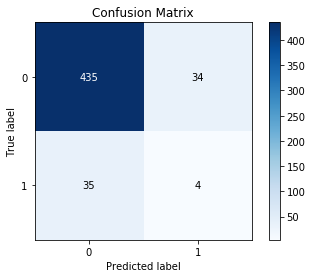

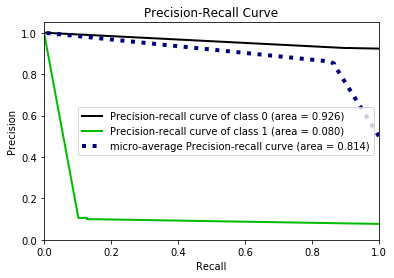

In [208]:
# Split data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.20, shuffle=True, random_state=3)

# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Define the algorithm we want to use for our model
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Create predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

# Print results
print("Predicted goals (test set):", sum(y_pred))
print("Sum of predicted goal probabilities (aka xG):", "{0:.2f}".format(sum(y_pred_prob[:,1])))
print("Actual goals (test set):", sum(y_test))
print('')
print(metrics.classification_report(y_test, y_pred))

# Plot results
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

skplt.metrics.plot_precision_recall(y_test, y_pred_prob)

I chose a random state of 3 here when splitting the data, and the results are quite a bit worse! Feel free to play around with different values on your own, but ultimately we will need to use a different method here to help mitigate this variance. As you've probably guessed already, this method is called cross-validation.

When carrying out cross validation we are still splitting the data randomly into a training set and a test set, just like we did with train/test split. The difference here is that we then repeat the process multiple times and average the results, which should produce a more accurate estimation of model performance. The most common approach is known as 'k-fold cross-validation', where the data is split into k subsets, or 'folds', with k-1 folds used to train the model and the remaining fold used for testing. For example, if we set k = 5 we will first use folds 2-5 for training and fold 1 for testing. We then repeat with folds 1, 3, 4 and 5 for training and use fold 2 for testing etc, until every observation has appeared in the test set exactly once.

This method is particularly advantageous with a small dataset, as unlike train/test split we are able to use the entire dataset to train the model. That said, with a bigger dataset you might want to consider still using train/test split, and then performing cross-validation on the training set before testing the model on the unseen test set. To help deal with class imbalance we can use something called 'stratified sampling', where each class is represented in roughly equal proportions in both the training and test set (e.g. about 10% of both sets would be 'goal' examples and 90% would be 'no goal'). Here is a nice illustration of stratified k-fold cross-validation, with the test set highlighted in yellow:

![Stratified k-fold cross-validation](http://www.fantasyfutopia.com/wp-content/uploads/2019/01/skfold_example.png)

In [209]:
# Define a function to check cross-validation results
# As always, feel free to come up with a better method to do this!
# Thankfully the cross-validation process will be simpler in later articles
def check_cross_validation(features, labels, num_folds, random_state=42):
    # Scale features to be between 0 and 1 (can speed up processing and help with accuracy)
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(features)
    y = labels

    # Define the cross-validation parameters
    # Common values of k are 5 and 10, as these have been shown experimentally to produce the best results
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    # Define the algorithm we want to use for our model
    clf = DecisionTreeClassifier(random_state=random_state)

    # Calculate precision and recall inside a loop using cross validation
    # First, create blank arrays to store the results in
    precision_0 = np.array([])
    recall_0 = np.array([])
    precision_1 = np.array([])
    recall_1 = np.array([])

    # Create training and test data using cross validation and fit model for each fold
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)

        # Create predicitons for the fold
        y_pred = clf.predict(X_test)

        # Calculate precision and recall scores
        # average=None means we will get a score for each class separately
        precision_scores = metrics.precision_score(y_test, y_pred, average=None)
        recall_scores = metrics.recall_score(y_test, y_pred, average=None)

        # Add the results to the arrays we created earlier
        precision_0 = np.append(precision_0, np.array(precision_scores[0]))
        precision_1 = np.append(precision_1, np.array(precision_scores[1]))
        recall_0 = np.append(recall_0, np.array(recall_scores[0]))
        recall_1 = np.append(recall_1, np.array(recall_scores[1]))

    # Print an average of the results from cross-validation
    print("Precision - no goal:", "{0:.4f}".format(precision_0.mean()))
    print("Recall - no goal:", "{0:.4f}".format(recall_0.mean()))
    print("Precision - goal:", "{0:.4f}".format(precision_1.mean()))
    print("Recall - goal:", "{0:.4f}".format(recall_1.mean()))
    print('')

print("Default classifier:")
check_cross_validation(features=features, labels=labels, num_folds=10)

print("SMOTE classifier:")
check_cross_validation(features=features_resampled, labels=labels_resampled, num_folds=10)

Default classifier:
Precision - no goal: 0.9194
Recall - no goal: 0.9198
Precision - goal: 0.2511
Recall - goal: 0.2445

SMOTE classifier:
Precision - no goal: 0.8567
Recall - no goal: 0.8553
Precision - goal: 0.8558
Recall - goal: 0.8566



We are still getting (surprisingly) good results with SMOTE re-sampling, which is great news since we can be more confident that our precision and recall scores are accurate when using cross-validation. If we really want to get fancy we could repeat the entire cross-validation process multiple times and average those results to get an even more accurate performance estimate, although this will be slower and more computationally expensive. __[We should also probably carry out the entire model building process (feature selection, parameter tuning etc) independently in each fold to ensure that we don't get a biased performance estimate](https://stats.stackexchange.com/questions/27750/feature-selection-and-cross-validation)__. I will explore this further in future articles.

## Conclusion
Thanks very much for reading! The last article had a fantastic response, so if you like this one please like or share it on social media! Keep an eye on __[@tom_whelan](https://twitter.com/tom_whelan)__ and __[@fantasyfutopia](https://twitter.com/fantasyfutopia)__ for updates on part 7, where I will be trying out different tree-based algorithms to see if we can achieve better results than with a basic decision tree classifier.